In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | Pa·s                  | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | m                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [2]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista
!pip install Rtree

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [5]:
WD_PATH = "/content/drive/MyDrive/Research/3d-1d"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))

import FEMSinkVelo
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import importlib
from graphnics import *

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [ ]:
# @title Define G = .vtk domain read
import vtk

def read_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    output = reader.GetOutput()

    G = FenicsGraph()

    damage_array = output.GetPointData().GetArray("Damage")
    for i in range(output.GetNumberOfPoints()):
        point = output.GetPoint(i)
        damage_value = damage_array.GetValue(i)
        G.add_node(i, pos=np.array(tuple(point)), damage=damage_value)

    radius_array = output.GetCellData().GetArray("Radius")
    for i in range(output.GetNumberOfCells()):
        cell = output.GetCell(i)
        point_ids = [cell.GetPointId(j) for j in range(cell.GetNumberOfPoints())]
        for j in range(len(point_ids) - 1):
            u = point_ids[j]
            v = point_ids[j + 1]
            radius_value = radius_array.GetValue(i) if radius_array else None
            G.add_edge(u, v, radius=radius_value)

    return G

file_path = "/content/drive/MyDrive/Research/3D-1D/oncopigData/ZPAF23S021/20230503/sortedDomain.vtk"
# file_path = WD_PATH + '/oncopigReferenceData/ZPAF23S018/20230531/vesselNetwork_upDated.vtk'
G = read_vtk(file_path)

In [27]:
#@title Define G = test graph
# Import the necessary library
G = FenicsGraph()

# Define the node labels and their corresponding integer IDs
node_mapping = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H'
}

# Define the coordinates for each node (x, y, z)
node_coords = {
    0: [0.000, 0.020, 0.015],    # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],    # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],    # G
    7: [0.038, 0.035, 0.015]    # H
}

# Define the edges along with their radii
edges_with_radii = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

# Create the FenicsGraph object
G = FenicsGraph()

# Add nodes to the graph with their positions
for node_id, coord in node_coords.items():
    G.add_node(node_id, pos=coord)

# Add edges to the graph with their radii
for u, v, radius in edges_with_radii:
    G.add_edge(u, v, radius=radius)

for edge_id, (u, v, data) in enumerate(G.edges(data=True)):
    print(f"Edge {edge_id}: ({u}, {v}) - Radius: {data['radius']}")

Edge 0: (0, 1) - Radius: 0.004
Edge 1: (1, 2) - Radius: 0.003
Edge 2: (1, 3) - Radius: 0.003
Edge 3: (2, 4) - Radius: 0.002
Edge 4: (2, 6) - Radius: 0.003
Edge 5: (3, 5) - Radius: 0.002
Edge 6: (3, 7) - Radius: 0.003


In [58]:
importlib.reload(FEMSinkVelo)

<module 'FEMSinkVelo' from '/content/drive/MyDrive/Research/3d-1d/modules/FEMSinkVelo.py'>

In [38]:
import FEMSinkVelo

In [59]:
fem_test = FEMSinkVelo.FEMSinkVelo(
    G=G,
    gamma = 1.0,
    gamma_R = 1.0,
    gamma_v = 1.0,
    gamma_a = 0,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.0, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008
)

# kappa ~= 0.33 * 10^-10 / x

[-0.008   -0.00208  0.00724] MARKED!


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 288.89it/s]


Applied BC! Non-empty list


In [64]:
import Visualizer
vis = Visualizer.Visualizer(fem_test.uh3d, fem_test.uh1d)

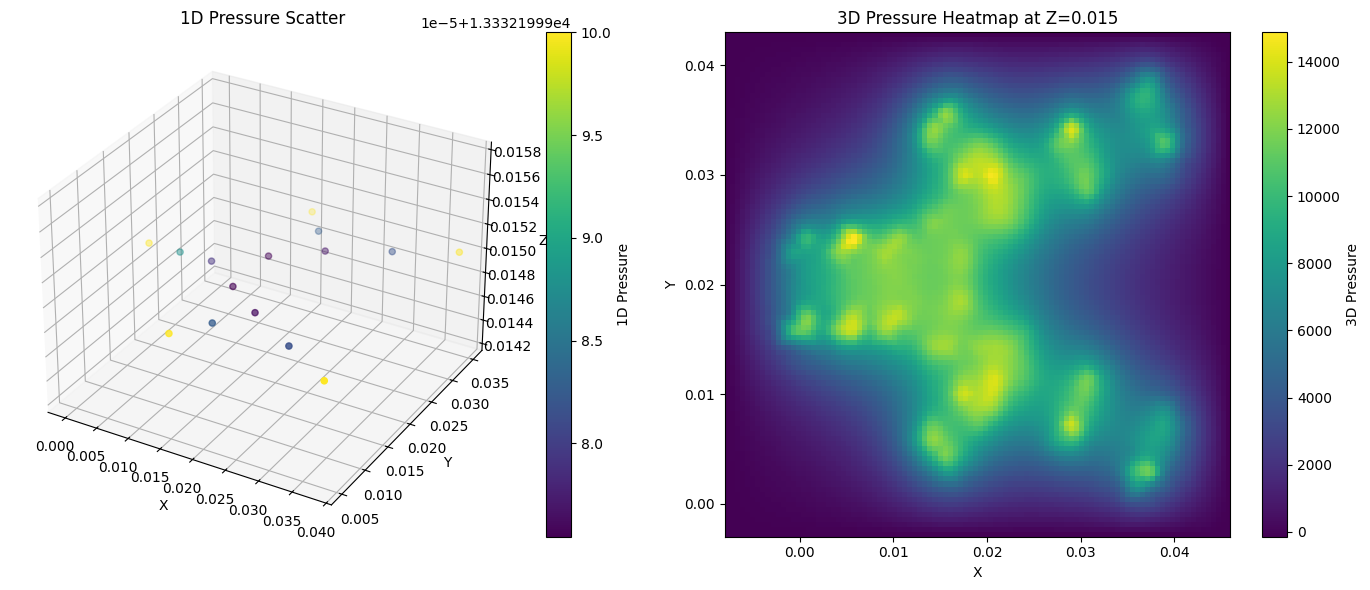

In [65]:
vis.visualize()

In [62]:
fem_test.save_vtk(os.path.join(WD_PATH, 'perfusion_results', 'xtest2'))